# Pronóstico de Series de Tiempo: Dólar y Variables Genéricas

**Objetivo:** Enseñar técnicas de **Feature Engineering** agnósticas al dominio. Aunque usamos el Dólar como ejemplo, estas técnicas (Lags, Ventanas Móviles, Indicadores Técnicos) funcionan para predecir demanda, ventas, clima o cualquier dato secuencial.

**El Reto:** Los modelos lineales simples no "entienden" el tiempo ni las dinámicas de mercado (rebotes, tendencias, aceleración). Debemos calcular estas métricas explícitamente.

**Metodología:**
1.  **Datos:** Descarga de Yahoo Finance (o sintéticos).
2.  **Ingeniería de Características (Enriquecida):**
    * **Memoria (Lags):** El valor ayer vs hoy.
    * **Estadística Móvil:** Tendencia central y volatilidad (Corto Plazo).
    * **Estadística Expansiva:** Tendencia histórica acumulada (Largo Plazo).
    * **Física del Precio (Indicadores Técnicos):** RSI (Fuerza), Bollinger (Rango), MACD (Tendencia).
    * **Calendario Económico:** Quincenas, cierres de mes y festivos (Efecto nómina).
    * **Tiempo Cíclico:** Patrones circulares (día semana/mes).
3.  **Modelado:** Ridge Regression (L2) para manejar la alta correlación.


In [1]:
# === 1. Importaciones y Configuración ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Librería para datos financieros
try:
    import yfinance as yf
except ImportError:
    print("!Advertencia! yfinance no está instalado. Se usarán datos sintéticos.")
    yf = None

# Librería para festivos (Opcional pero recomendada)
try:
    import holidays
except ImportError:
    print("!Advertencia! La librería 'holidays' no está instalada. La feature de festivos será 0.")
    holidays = None

# Preprocesamiento y Métricas
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
np.random.seed(42) # Reproducibilidad

## 2. Obtención de Datos

Usaremos el Dólar (COP=X) como nuestro "conejillo de indias", pero imagina que estos datos podrían ser "Ventas Diarias" o "Temperatura".

In [2]:
def generar_datos_sinteticos(dias=730, precio_inicial=4000):
    """Genera datos simulados si falla la descarga real."""
    print("--- Generando datos sintéticos (Modo Offline) ---")
    fechas = pd.date_range(end=datetime.now(), periods=dias, freq='D')

    # Caminata Aleatoria con tendencia y estacionalidad simulada
    retornos = np.random.normal(loc=0.0001, scale=0.01, size=dias)
    precio_base = precio_inicial * np.cumprod(1 + retornos)

    df = pd.DataFrame({'fecha': fechas, 'precio_base': precio_base})

    # Agregar estacionalidad artificial
    df['efecto_mes'] = np.sin(2 * np.pi * df['fecha'].dt.day / 30) * 15
    df['precio'] = df['precio_base'] + df['efecto_mes']

    return df[['fecha', 'precio']].set_index('fecha')

def obtener_datos_dolar(ticker="COP=X", periodo="2y"):
    """Descarga datos o usa sintéticos."""
    if yf is None:
        return generar_datos_sinteticos()

    print(f"Intentando descargar datos reales para {ticker}...")
    try:
        datos = yf.download(ticker, period=periodo, interval="1d", progress=False)

        if datos.empty: raise ValueError("Datos vacíos")

        if isinstance(datos.columns, pd.MultiIndex):
            precios = datos['Close'][ticker]
        else:
            precios = datos['Close']

        df = pd.DataFrame(precios)
        df.columns = ['precio']
        df.index.name = 'fecha'

        # Rellenar fines de semana para continuidad en cálculos de lags
        df = df.asfreq('D').ffill()

        print(f"¡Éxito! Se descargaron {len(df)} registros.")
        return df

    except Exception as e:
        print(f"Error descargando datos: {e}")
        return generar_datos_sinteticos()

df = obtener_datos_dolar()

Intentando descargar datos reales para COP=X...


/tmp/ipython-input-661068087.py:25: FutureWarning: YF.download() has changed argument auto_adjust default to True
  datos = yf.download(ticker, period=periodo, interval="1d", progress=False)


¡Éxito! Se descargaron 731 registros.


## 3. Feature Engineering Avanzado (Completo)

Vamos a crear características que sirvan para cualquier serie temporal.

### 3.1 Calendario Económico y Cíclico
Aquí capturamos el comportamiento humano: Pagos de nómina, cierres de mes y festivos.

In [3]:
def features_calendario(df):
    df_temp = df.copy()

    # --- A. Variables Cíclicas (Matemáticas) ---
    df_temp['dia_semana'] = df_temp.index.dayofweek
    df_temp['dia_mes'] = df_temp.index.day

    # Seno/Coseno para continuidad circular (Lunes cerca de Domingo, Enero cerca de Diciembre)
    df_temp['dia_semana_sin'] = np.sin(2 * np.pi * df_temp['dia_semana'] / 7)
    df_temp['dia_semana_cos'] = np.cos(2 * np.pi * df_temp['dia_semana'] / 7)
    df_temp['dia_mes_sin'] = np.sin(2 * np.pi * df_temp['dia_mes'] / 30)
    df_temp['dia_mes_cos'] = np.cos(2 * np.pi * df_temp['dia_mes'] / 30)

    # --- B. Efectos de Nómina (Humanos) ---

    # Es Quincena: Día 15 o fin de mes (pagos de salario -> presión venta de dólares)
    df_temp['es_quincena'] = ((df_temp.index.day == 15) | (df_temp.index.is_month_end)).astype(int)

    # Es Fin de Mes: Últimos 5 días (cierres contables y de metas)
    df_temp['es_cierre_mes'] = (df_temp.index.day >= 25).astype(int)

    # --- C. Festivos (Colombia) ---
    if holidays:
        # Cargamos festivos de Colombia (CO)
        festivos_co = holidays.CO()
        df_temp['es_festivo'] = df_temp.index.isin(festivos_co).astype(int)
    else:
        df_temp['es_festivo'] = 0 # Fallback si no hay librería

    return df_temp.drop(['dia_semana', 'dia_mes'], axis=1)

df_features = features_calendario(df)

### 3.2 Lags, Ventanas Móviles y Expansivas (Estadística)

* **Lags:** ¿Qué pasó ayer?
* **Rolling (Móvil):** ¿Qué pasó en la última semana?
* **Expanding (Expansiva):** ¿Qué ha pasado en **toda la historia** hasta hoy? (Inspirado en el script de E-commerce)

In [4]:
data = df_features.copy()

# --- A. LAG FEATURES (El pasado puntual) ---
data['precio_lag_1'] = data['precio'].shift(1) # Ayer
data['precio_lag_2'] = data['precio'].shift(2) # Antier
data['precio_lag_7'] = data['precio'].shift(7) # Hace una semana

# --- B. ROLLING FEATURES (Tendencia Reciente) ---
# Usamos .rolling(window=N)
# Shift(1) es vital para evitar LEAKAGE
data['media_movil_7'] = data['precio'].shift(1).rolling(window=7).mean()
data['media_movil_30'] = data['precio'].shift(1).rolling(window=30).mean()
data['volatilidad_7'] = data['precio'].shift(1).rolling(window=7).std()

# --- C. EXPANDING FEATURES (Tendencia Histórica) ---
# Usamos .expanding(). Similar al "conversion rate" histórico del e-commerce.
# ¿Cuál es el precio máximo que hemos visto "hasta hoy"?
data['maximo_historico'] = data['precio'].shift(1).expanding().max()

# ¿Cuál es el promedio de "toda la vida" hasta hoy?
data['promedio_historico'] = data['precio'].shift(1).expanding().mean()

# --- D. MOMENTUM (Inercia) ---
# Diferencia entre ayer y hace 3 días (velocidad reciente)
data['momentum_3d'] = data['precio'].shift(1) - data['precio'].shift(4)

### 3.3 Indicadores Técnicos (Física del Mercado)

Aquí implementamos lógica de "trading" o dinámica de sistemas. Estas métricas son universales.

1.  **RSI (Relative Strength Index):** Mide la "velocidad" y el cambio de los movimientos de precios.
    * *Lógica:* Si sube muchos días seguidos, el RSI es alto (sobrecompra -> posible caída).
2.  **Bandas de Bollinger:** Miden si el precio está "estadísticamente lejos" de su promedio.
    * *Lógica:* Si el precio rompe la banda superior, es una anomalía positiva.
3.  **MACD (Moving Average Convergence Divergence):** Mide la relación entre dos medias móviles.
    * *Lógica:* Detecta cambios en la dirección de la tendencia (aceleración/desaceleración).

In [5]:
# --- A. RSI (Fuerza Relativa) ---
# Calculamos cambios diarios
delta = data['precio'].shift(1).diff() # Diferencia entre ayer y antier

# Separamos ganancias y pérdidas
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()

rs = gain / loss
data['RSI'] = 100 - (100 / (1 + rs))
data['RSI'] = data['RSI'].fillna(50) # Rellenar nulos iniciales con valor neutro

# --- B. Bandas de Bollinger (Posición Relativa) ---
# Usamos media y std de 20 días
ma_20 = data['precio'].shift(1).rolling(window=20).mean()
std_20 = data['precio'].shift(1).rolling(window=20).std()

upper_band = ma_20 + (std_20 * 2)
lower_band = ma_20 - (std_20 * 2)

# Feature: %B (Dónde está el precio respecto a las bandas)
# 0 = Banda inferior, 1 = Banda superior, >1 = Rompió techo
data['Bollinger_PctB'] = (data['precio'].shift(1) - lower_band) / (upper_band - lower_band)

# --- C. MACD (Tendencia) ---
# EMA (Exponential Moving Average) da más peso a datos recientes
ema_12 = data['precio'].shift(1).ewm(span=12, adjust=False).mean()
ema_26 = data['precio'].shift(1).ewm(span=26, adjust=False).mean()

data['MACD'] = ema_12 - ema_26
data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()

# Limpieza final de NaNs generados por ventanas grandes
print(f"Filas antes de limpieza: {len(data)}")
data = data.dropna()
print(f"Filas para modelado: {len(data)}")

# Mostrar las nuevas features (Expandidas)
cols_nuevas = ['precio', 'maximo_historico', 'promedio_historico']
display(data[cols_nuevas].tail(10))

Filas antes de limpieza: 731
Filas para modelado: 701


,precio,maximo_historico,promedio_historico
fecha,,,
2025-11-17,3701.260254,4480.0,4070.681864
2025-11-18,3754.500000,4480.0,4070.170200
2025-11-19,3719.800049,4480.0,4069.733588
2025-11-20,3712.250000,4480.0,4069.250255
2025-11-21,3762.169922,4480.0,4068.757840
2025-11-22,3762.169922,4480.0,4068.335543
2025-11-23,3762.169922,4480.0,4067.914407
2025-11-24,3717.585693,4480.0,4067.494429
2025-11-25,3791.250000,4480.0,4067.014444


## 4. Split Cronológico
Train (Pasado) vs Test (Futuro).

In [6]:
target = 'precio'
features = [col for col in data.columns if col != target]

# Últimos 60 días para test
test_days = 60
split_date = data.index.max() - timedelta(days=test_days)

train = data[data.index <= split_date]
test = data[data.index > split_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

print(f"Variables usadas ({len(features)}): {features}")

Variables usadas (20): ['dia_semana_sin', 'dia_semana_cos', 'dia_mes_sin', 'dia_mes_cos', 'es_quincena', 'es_cierre_mes', 'es_festivo', 'precio_lag_1', 'precio_lag_2', 'precio_lag_7', 'media_movil_7', 'media_movil_30', 'volatilidad_7', 'maximo_historico', 'promedio_historico', 'momentum_3d', 'RSI', 'Bollinger_PctB', 'MACD', 'MACD_Signal']


## 5. Modelado y Evaluación (Ridge Regression)

Ridge es ideal aquí porque indicadores como `media_movil_7` y `media_movil_30` están correlacionados. Ridge maneja esa redundancia sin explotar.

MAE (Error Promedio): $21.84
R2 Score: 0.8027


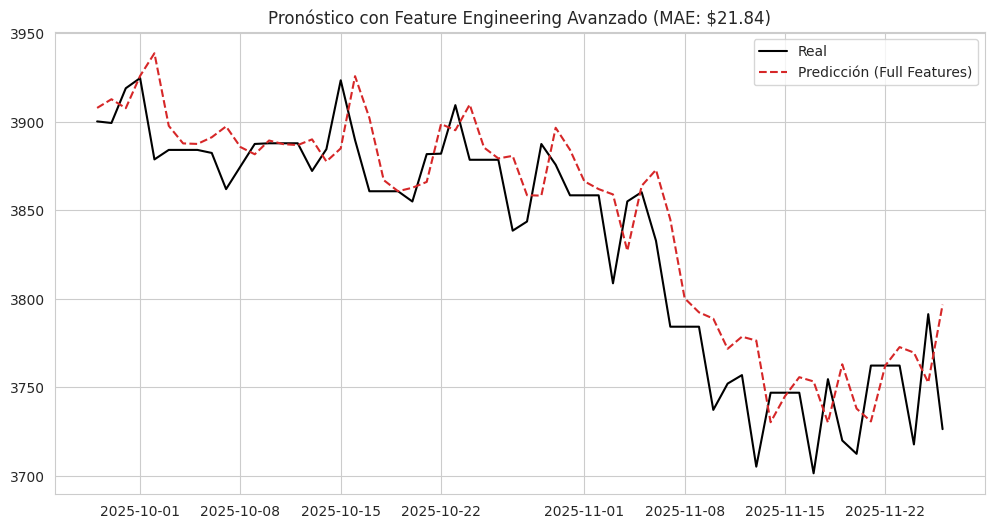

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge(alpha=1.0))
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"MAE (Error Promedio): ${mae:.2f}")
print(f"R2 Score: {r2:.4f}")

# Gráfico de Resultados
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Real', color='black')
plt.plot(y_test.index, preds, label='Predicción (Full Features)', color='#d62728', linestyle='--')
plt.title(f"Pronóstico con Feature Engineering Avanzado (MAE: ${mae:.2f})")
plt.legend()
plt.show()

## 6. Importancia de Variables
¿Qué variable pesó más? ¿El Lag (memoria), el RSI (física) o la Quincena (calendario)?

/tmp/ipython-input-566725722.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coefs, x='Peso', y='Feature', palette='viridis')


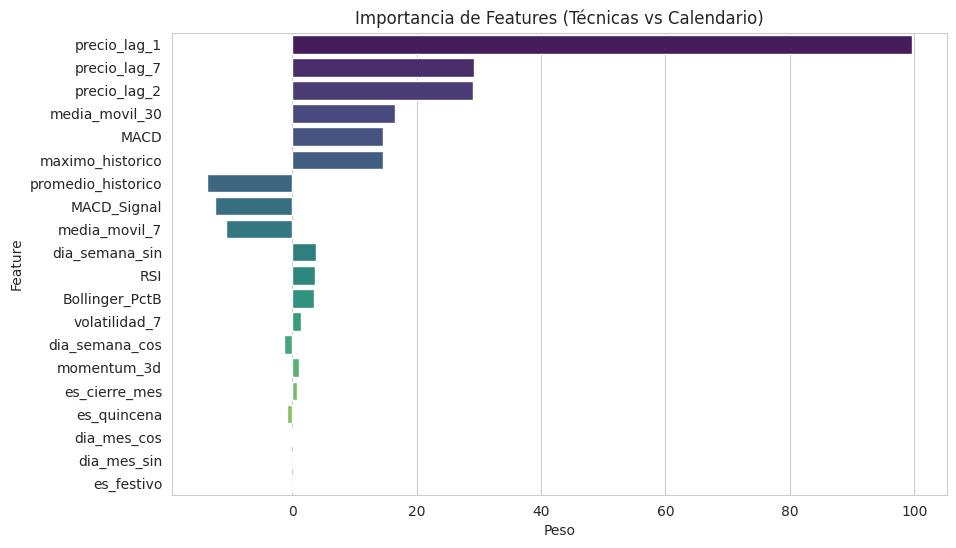

In [8]:
coefs = pd.DataFrame({
    'Feature': features,
    'Peso': pipeline.named_steps['model'].coef_
}).sort_values(by='Peso', key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coefs, x='Peso', y='Feature', palette='viridis')
plt.title("Importancia de Features (Técnicas vs Calendario)")
plt.show()